In [3]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

In [4]:
batch_size = 16
# name of the dataset
dataset_name = "../input/celeba-dataset/img_align_celeba/img_align_celeba"
n_cpu = 4

In [5]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, img_size=128, mask_size=64, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.img_size = img_size
        self.mask_size = mask_size
        self.mode = mode
        self.files = sorted(glob.glob("%s/*.jpg" % root))
        self.files = self.files[:-4000] if mode == "train" else self.files[-4000:]

    def apply_random_mask(self, img):
        """Randomly masks image"""
        y1, x1 = np.random.randint(0, self.img_size - self.mask_size, 2)
        y2, x2 = y1 + self.mask_size, x1 + self.mask_size
        masked_part = img[:, y1:y2, x1:x2]
        masked_img = img.clone()
        masked_img[:, y1:y2, x1:x2] = 1

        return masked_img, masked_part

    def apply_center_mask(self, img):
        """Mask center part of image"""
        # Get upper-left pixel coordinate
        i = (self.img_size - self.mask_size) // 2
        masked_img = img.clone()
        masked_img[:, i : i + self.mask_size, i : i + self.mask_size] = 1

        return masked_img, i

    def __getitem__(self, index):

        img = Image.open(self.files[index % len(self.files)])
        img = self.transform(img)
        if self.mode == "train":
            # For training data perform random mask
            masked_img, aux = self.apply_random_mask(img)
        else:
            # For test data mask the center of the image
            masked_img, aux = self.apply_center_mask(img)

        return img, masked_img, aux

    def __len__(self):
        return len(self.files)

In [6]:
img_size = 128
transforms_ = [
    transforms.Resize((img_size, img_size), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]
    
dataloader = DataLoader(
    ImageDataset(dataset_name, transforms_=transforms_),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)
test_dataloader = DataLoader(
    ImageDataset(dataset_name, transforms_=transforms_, mode="val"),
    batch_size=12,
    shuffle=True,
    num_workers=1,
)


In [7]:
class Generator(nn.Module):
    def __init__(self, channels=3):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 4000, 1),
            
            nn.ConvTranspose2d(4000, 512, 4, stride=2, padding=1), #upsample 
            nn.BatchNorm2d(512, 0.8),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1), #upsample 
            nn.BatchNorm2d(256, 0.8),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), #upsample 
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), #upsample 
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(),
            nn.Conv2d(64, channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
model = Generator(channels=3)
model.load_state_dict(torch.load('/kaggle/input/outputganmodel/generator.pth', map_location=device))
model.eval()

Generator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2)
    (14): Conv2d(512, 4000, kernel_si

In [10]:
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [16]:
img, masked_imgs, aux = next(iter(test_dataloader))

In [17]:
g = model(masked_imgs.type(Tensor))
g.shape

torch.Size([12, 3, 64, 64])

In [18]:
img_real = img.cpu().detach().numpy()
img_real = np.transpose(img_real[0], (1, 2, 0))

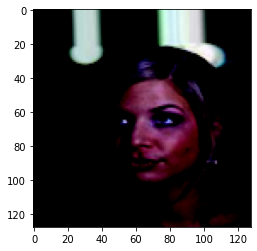

In [19]:
plt.imshow(img_real)

In [20]:
img_real.shape

(128, 128, 3)

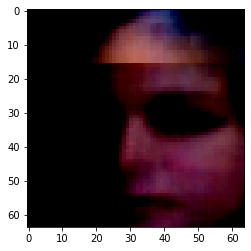

In [21]:
img_temp = g.cpu().detach().numpy()
plt.imshow(np.transpose(img_temp[0], (1, 2, 0)))

In [25]:
img_test, mask_test, aux_test = next(iter(test_dataloader))

In [ ]:
img_test

In [101]:
def vis(idx):
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15,10)
    a = img[idx].cpu().detach().numpy()
    a = np.transpose(a, (1, 2, 0))
    ax[0].imshow(a)
    ax[0].set_title("The Original Image")
    ax[1].imshow(np.transpose(masked_imgs[0], (1, 2, 0)))
    ax[1].set_title("The masked Image")
    img_temp = g.cpu().detach().numpy()
    ax[2].imshow(np.transpose(img_temp[idx], (1, 2, 0)))
    ax[2].set_title("The predict Image")

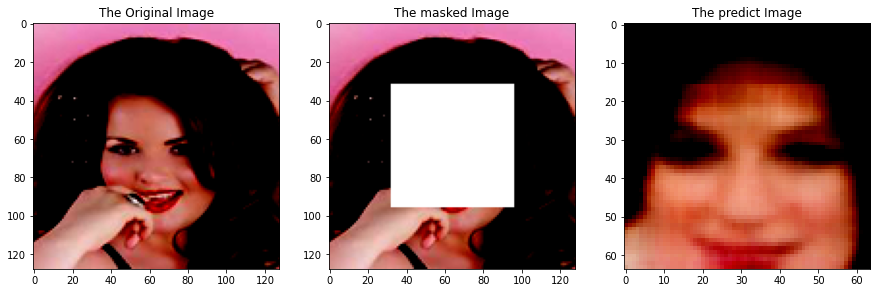

In [102]:
vis(0)